## Meta Models vs Final Prediction Error

In [56]:
# Define variables
IS_FILTERED = True
ARCHIVED = "error_observation_cpu"
SHOW_LAST_APPEARANCE = 500
CUT_LAST_APPEARANCE = 400

In [57]:
# Import libraries
import sys
sys.path.append('../../prediction/')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from putils.observation import compute_rmse, compute_mae, load_data

In [58]:
# Define plotting function
def plot_error_over_time(
        df_meta,
        df_final,
        # target_cols = ['LINEAR_REGRESSION', 'RANDOM_FOREST', 'FEEDFORWARD_NEURAL_NETWORK', 'Predicted'],
        target_cols = ['LINEAR_REGRESSION', 'RANDOM_FOREST', 'FEEDFORWARD_NEURAL_NETWORK'], # Considered only the L2 models
        error_type = 'RMSE',
    ):
    compute_error_fn = compute_rmse if error_type == 'RMSE' else compute_mae

    # Concatenating the DataFrames without renaming 'Raw' since it's the same in both
    # combined_df_simple = pd.concat([df_meta, df_final], axis=1)
    combined_df_simple = pd.concat([df_meta], axis=1) # Only use meta data
    
    # Dropping duplicate 'Raw' and 'Actual' columns from the combined DataFrame
    combined_df_no_duplicates = combined_df_simple.loc[:,~combined_df_simple.columns.duplicated()]

    # Recalculating incremental RMSE using the non-duplicate 'Raw' column
    error_over_time_no_duplicates = pd.DataFrame(index=combined_df_no_duplicates.index, columns=target_cols)

    # Compute error incrementally for each time point
    for time_point in combined_df_no_duplicates.index:
        for col in target_cols:
            # Calculate error from start to the current time point
            error_over_time_no_duplicates.at[time_point, col] = np.sqrt(
                compute_error_fn(combined_df_no_duplicates.loc[:time_point, 'Raw'], combined_df_no_duplicates.loc[:time_point, col])
            )

    # Convert error values to numeric for plotting
    error_over_time_no_duplicates = error_over_time_no_duplicates.apply(pd.to_numeric)

    # Plotting incremental error over time
    plt.figure(figsize=(12, 6))
    for col in error_over_time_no_duplicates.columns:
        plt.plot(error_over_time_no_duplicates.index, error_over_time_no_duplicates[col], label=f'{error_type} {col}')

    plt.xlabel('Time')
    plt.ylabel('RMSE')
    plt.title('Incremental RMSE of Each Model Over Time Using Non-Duplicate Raw Data')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotate the dates for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping of tick labels
    plt.show()

    # Calculating the final error of each model for the entire dataset
    final_error_values = {}
    for col in target_cols:
        final_error_values[col] = np.sqrt(
            compute_error_fn(combined_df_no_duplicates['Raw'], combined_df_no_duplicates[col])
        )

    # Displaying the final error values for each model
    for key, value in final_error_values.items():
        print(f'Final {error_type} {key}: {value}')

    return error_over_time_no_duplicates

In [59]:
# Load data
datafile = "prediction_result_filtered.csv" if IS_FILTERED else "prediction_result.csv"
dir = "../../source/"

df_meta = load_data("l2", datafile=datafile, archived=ARCHIVED, last_appearance=SHOW_LAST_APPEARANCE, source=dir)
df_final = load_data("l3", datafile=datafile, archived=ARCHIVED, last_appearance=SHOW_LAST_APPEARANCE, source=dir)

# Cut last appearance
if CUT_LAST_APPEARANCE > 0:
    df_meta = df_meta.iloc[:-CUT_LAST_APPEARANCE]
    df_final = df_final.iloc[:-CUT_LAST_APPEARANCE]

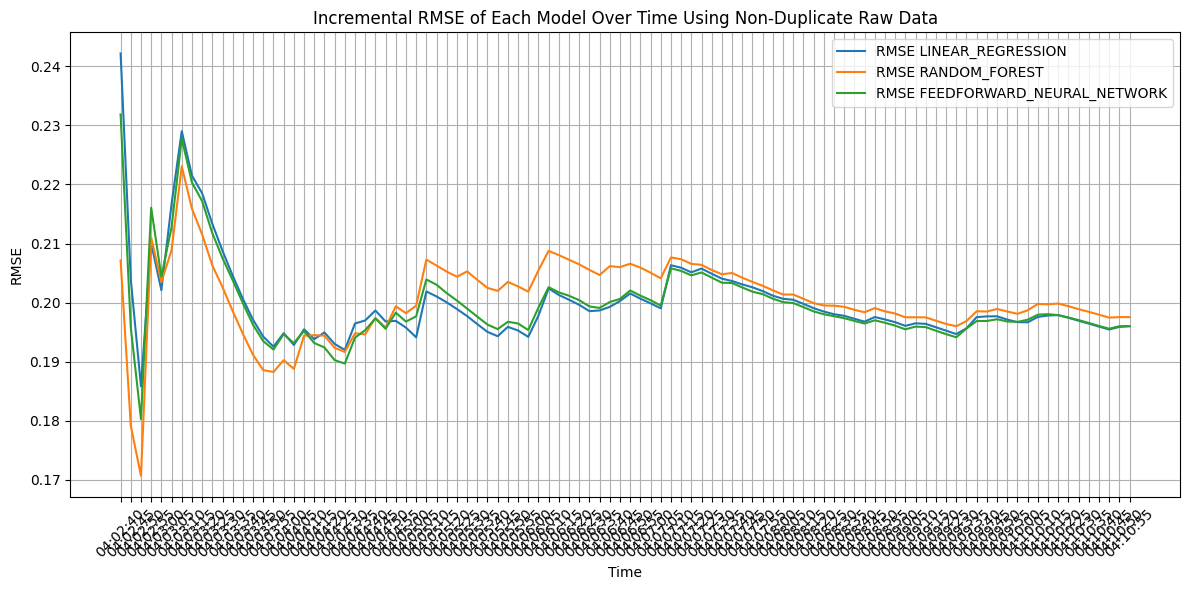

Final RMSE LINEAR_REGRESSION: 0.19601524422582747
Final RMSE RANDOM_FOREST: 0.19754697845382374
Final RMSE FEEDFORWARD_NEURAL_NETWORK: 0.19603367941450675


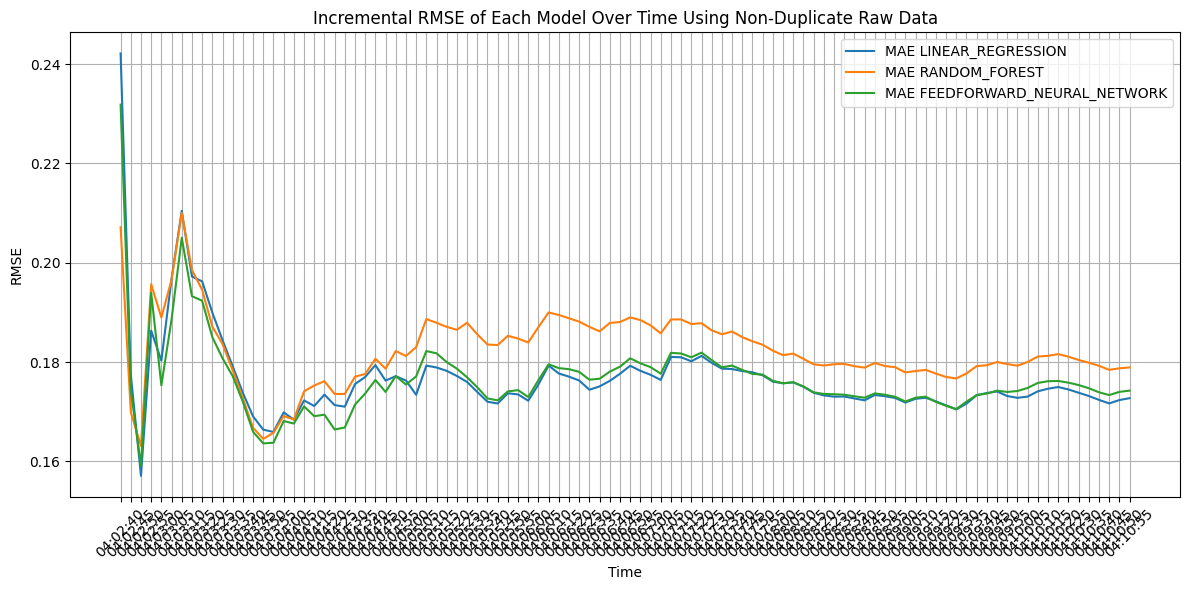

Final MAE LINEAR_REGRESSION: 0.1727104925404736
Final MAE RANDOM_FOREST: 0.17891096482142543
Final MAE FEEDFORWARD_NEURAL_NETWORK: 0.17423963819936875


,LINEAR_REGRESSION,RANDOM_FOREST,FEEDFORWARD_NEURAL_NETWORK
FormattedTime,,,
04:02:40,0.242163,0.207155,0.231847
04:02:45,0.177431,0.169873,0.174333
04:02:50,0.157064,0.163061,0.159123
04:02:55,0.186322,0.195661,0.193936
04:03:00,0.180277,0.188955,0.175311
...,...,...,...
04:10:35,0.173156,0.179862,0.174719
04:10:40,0.172376,0.179234,0.173903
04:10:45,0.171659,0.178426,0.173343


In [60]:
# Plot error over time
errors = plot_error_over_time(df_meta, df_final, error_type='RMSE')
plot_error_over_time(df_meta, df_final, error_type='MAE')

In [61]:
# save data to csv
time_now = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")
file = f"error_over_time_{ARCHIVED}_{time_now}.csv"
errors.to_csv(file)